This lab on Model Validation using Validation and Cross-Validation in R comes from p. 248-251 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It was re-implemented in Fall 2016 in `tidyverse` format by Amelia McNamara and R. Jordan Crouser at Smith College.

In [1]:
list.of.packages <- c("dplyr","ISLR","leaps")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

In [2]:
library(ISLR)
library(leaps)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Model selection using the Validation Set Approach

In Lab 8, we saw that it is possible to choose among a set of models of different
sizes using $C_p$, BIC, and adjusted $R^2$. We will now consider how to do this
using the validation set and cross-validation approaches.

As in Lab 8, we'll be working with the `Hitters` dataset from `ISLR`. Since we're trying to predict `Salary` and we know from last time that some are missing, let's first drop all the rows with missing values:

In [3]:
Hitters = na.omit(Hitters)

In order for these approaches to yield accurate estimates of the test
error, we must use *only the training observations* to perform all aspects of
model-fitting — including variable selection. Therefore, the determination of
which model of a given size is best must be made using *only the training
observations*. This point is subtle but important. If the full data set is used
to perform the best subset selection step, the validation set errors and
cross-validation errors that we obtain will not be accurate estimates of the
test error.

In order to use the validation set approach, we begin by splitting the
observations into a training set and a test set as before. Here, we've decided to split the data in half using the `sample_frac()` method:

In [4]:
set.seed(1)

train = Hitters %>%
  sample_frac(0.5)

test = Hitters %>%
  setdiff(train)

Now, we apply `regsubsets()` to the training set in order to perform best
subset selection\*.

( \*Note: If you're trying to complete this lab on a machine that can't handle calculating the **best subset**, or if you just want it to run a little faster, try forward or backward selection instead by adding the `method = "forward"` or `method = "backward"` parameter to your call to `regsubsets()`. You'll get slightly different values, but the concepts are the same.)

In [5]:
regfit_best_train = regsubsets(Salary~., data = train, nvmax = 19)

Notice that we subset the `Hitters` data frame directly in the call in order
to access only the training subset of the data, using the expression
`Hitters[train,]`. We now compute the validation set error for the best
model of each model size. We first make a model matrix from the test
data.

In [6]:
test_mat = model.matrix (Salary~., data = test)

The `model.matrix()` function is used in many regression packages for building an $X$ matrix from data. Now we run a loop, and for each size $i$, we
extract the coefficients from `regfit.best` for the best model of that size,
multiply them into the appropriate columns of the test model matrix to
form the predictions, and compute the test MSE.

In [7]:
val_errors = rep(NA,19)

# Iterates over each size i
for(i in 1:19){
    
    # Extract the vector of predictors in the best fit model on i predictors
    coefi = coef(regfit_best_train, id = i)
    
    # Make predictions using matrix multiplication of the test matirx and the coefficients vector
    pred = test_mat[,names(coefi)]%*%coefi
    
    # Calculate the MSE
    val_errors[i] = mean((test$Salary-pred)^2)
}

Now let's plot the errors, and find the model that minimizes it:

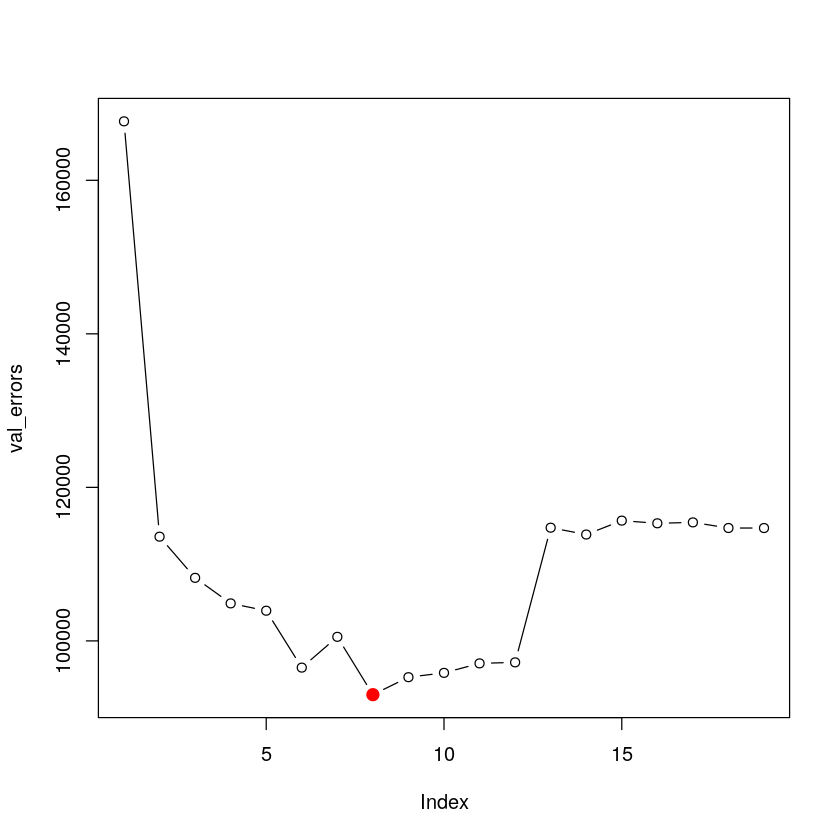

In [8]:
# Find the model with the smallest error
min = which.min(val_errors)

# Plot the errors for each model size
plot(val_errors, type = 'b')
points(min, val_errors[min][1], col = "red", cex = 2, pch = 20)

Viola! We find that the best model (according to the validation set approach) is the one that contains 10 predictors.

This was a little tedious, partly because there is no `predict()` method
for `regsubsets()`. Since we will be using this function again, we can capture
our steps above and write our own `predict()` method:

In [9]:
predict.regsubsets = function(object,newdata,id,...){
      form = as.formula(object$call[[2]]) # Extract the formula used when we called regsubsets()
      mat = model.matrix(form,newdata)    # Build the model matrix
      coefi = coef(object,id=id)          # Extract the coefficiants of the ith model
      xvars = names(coefi)                # Pull out the names of the predictors used in the ith model
      mat[,xvars]%*%coefi               # Make predictions using matrix multiplication
}

This function pretty much mimics what we did above. The one tricky
part is how we extracted the formula used in the call to `regsubsets()`, but you don't need to worry too much about the mechanics of this right now. We'll use this function to make our lives a little easier when we do cross-validation.

Now that we know what we're looking for, let's perform best subset selection on the full dataset (up to 10 predictors) and select the best 10-predictor model. It is important that we make use of the *full
data set* in order to obtain more accurate coefficient estimates. Note that
we perform best subset selection on the full data set and select the best 10-predictor
model, rather than simply using the predictors that we obtained
from the training set, because the best 10-predictor model on the **full data
set** may differ from the corresponding model on the training set.

In [10]:
regfit_best = regsubsets(Salary~., data = Hitters, nvmax = 10)

In fact, we see that the best ten-variable model on the full data set has a
**different set of predictors** than the best ten-variable model on the training
set:

In [11]:
coef(regfit_best, 10)
coef(regfit_best_train, 10)

(Intercept)        AtBat         Hits        Walks       CAtBat        CRuns 
 162.5354420   -2.1686501    6.9180175    5.7732246   -0.1300798    1.4082490 
        CRBI       CWalks    DivisionW      PutOuts      Assists 
   0.7743122   -0.8308264 -112.3800575    0.2973726    0.2831680

(Intercept)       AtBat        Hits       HmRun        Runs       Walks 
 361.489102   -2.270854    7.915154    9.516184   -6.732495    9.640831 
      Years       CRuns      CWalks   DivisionW     PutOuts 
 -37.215057    1.755137   -1.017066 -138.483094    0.309621

# Model selection using Cross-Validation

Now let's try to choose among the models of different sizes using cross-validation.
This approach is somewhat involved, as we must perform best
subset selection\* within each of the $k$ training sets. Despite this, we see that
with its clever subsetting syntax, `R` makes this job quite easy. First, we
create a vector that assigns each observation to one of $k = 10$ folds, and
we create a matrix in which we will store the results:

\* or forward selection / backward selection

In [12]:
k = 10        # number of folds
set.seed(1)   # set the random seed so we all get the same results

# Assign each observation to a single fold
folds = sample(1:k, nrow(Hitters), replace = TRUE)

# Create a matrix to store the results of our upcoming calculations
cv_errors = matrix(NA, k, 19, dimnames = list(NULL, paste(1:19)))

Now let's write a for loop that performs cross-validation. In the $j^{th}$ fold, the
elements of folds that equal $j$ are in the test set, and the remainder are in
the training set. We make our predictions for each model size (using our
new $predict()$ method), compute the test errors on the appropriate subset,
and store them in the appropriate slot in the matrix `cv.errors`.

In [13]:
# Outer loop iterates over all folds
for(j in 1:k){
    
    # The perform best subset selection on the full dataset, minus the jth fold
    best_fit = regsubsets(Salary~., data = Hitters[folds!=j,], nvmax=19)
    
    # Inner loop iterates over each size i
    for(i in 1:19){
        
        # Predict the values of the current fold from the "best subset" model on i predictors
        pred = predict(best_fit, Hitters[folds==j,], id=i)
        
        # Calculate the MSE, store it in the matrix we created above
        cv_errors[j,i] = mean((Hitters$Salary[folds==j]-pred)^2)
    }
}

This has filled up the `cv_._errors` matrix such that the $(i,j)^{th}$ element corresponds
to the test MSE for the $i^{th}$ cross-validation fold for the best $j$-variable
model.  We can then use the `apply()` function to take the `mean` over the columns of this
matrix. This will give us a vector for which the $j^{th}$ element is the cross-validation
error for the $j$-variable model.

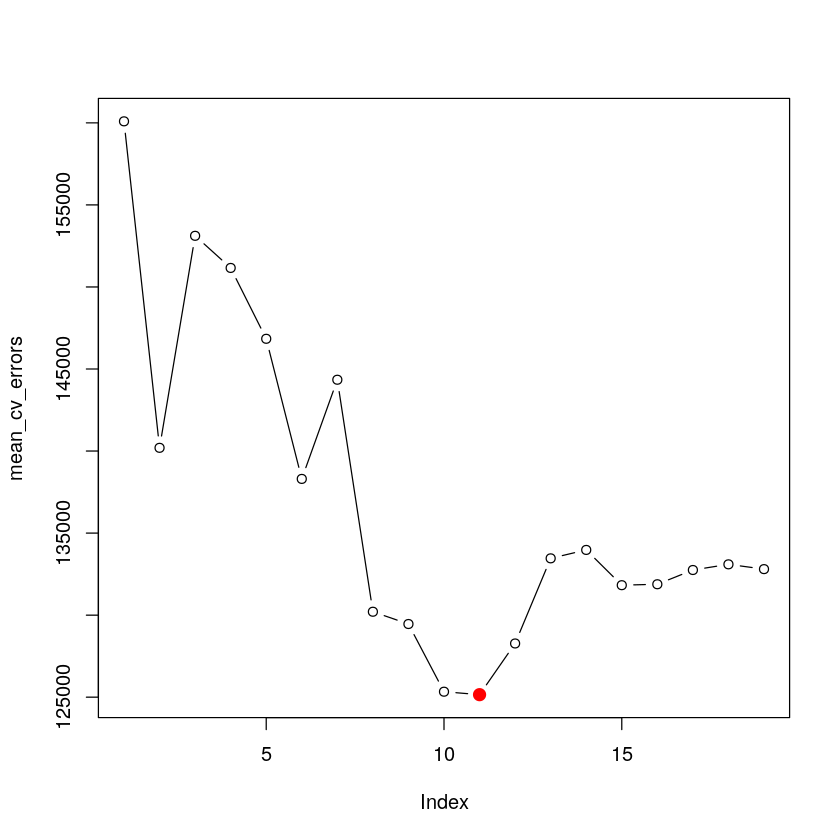

In [14]:
# Take the mean of over all folds for each model size
mean_cv_errors = apply(cv_errors, 2, mean)

# Find the model size with the smallest cross-validation error
min = which.min(mean_cv_errors)

# Plot the cross-validation error for each model size, highlight the min
plot(mean_cv_errors, type='b')
points(min, mean_cv_errors[min][1], col = "red", cex = 2, pch = 20)

We see that cross-validation selects an 11-predictor model. Now let's use
best subset selection on the full data set in order to obtain the 11-predictor
model.

In [15]:
reg_best = regsubsets(Salary~., data = Hitters, nvmax = 19)
coef(reg_best, 11)

(Intercept)        AtBat         Hits        Walks       CAtBat        CRuns 
 135.7512195   -2.1277482    6.9236994    5.6202755   -0.1389914    1.4553310 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
   0.7852528   -0.8228559   43.1116152 -111.1460252    0.2894087    0.2688277

For comparison, let's also take a look at the statistics from last lab:

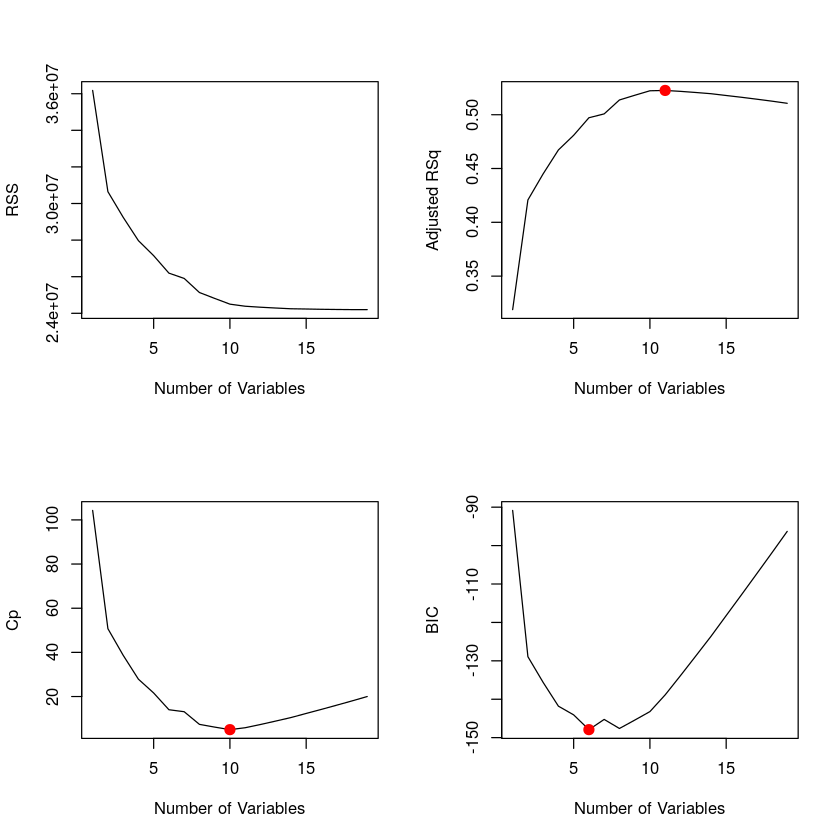

In [16]:
par(mfrow=c(2,2))

reg_summary = summary(reg_best)

# Plot RSS
plot(reg_summary$rss, xlab = "Number of Variables", ylab = "RSS", type = "l")

# Plot Adjusted R^2, highlight max value
plot(reg_summary$adjr2, xlab = "Number of Variables", ylab = "Adjusted RSq", type = "l")
max = which.max(reg_summary$adjr2)
points(max, reg_summary$adjr2[max], col = "red", cex = 2, pch = 20)

# Plot Cp, highlight min value
plot(reg_summary$cp, xlab = "Number of Variables", ylab = "Cp", type = "l")
min = which.min(reg_summary$cp)
points(min,reg_summary$cp[min], col = "red", cex = 2, pch = 20)

# Plot BIC, highlight min value
plot(reg_summary$bic, xlab = "Number of Variables", ylab = "BIC", type = "l")
min = which.min(reg_summary$bic)
points(min, reg_summary$bic[min], col = "red", cex = 2, pch = 20)

Notice how some of the indicators agree with the cross-validated model, and others are very different?

# Your turn!

Now it's time to test out these approaches (best / forward / backward selection) and evaluation methods (adjusted training error, validation set, cross validation) on other datasets. You may want to work with a team on this portion of the lab.

You may use any of the datasets included in the `ISLR` package, or choose one from the UCI machine learning repository (http://archive.ics.uci.edu/ml/datasets.html). Download a dataset, and try to determine the optimal set of parameters to use to model it!

In [17]:
# Your code here

To get credit for this lab, please post your answers to the following questions:

* What dataset did you choose?
* Which selection techniques did you try?
* Which evaluation techniques did you try?
* What did you determine was the best set of parameters to model this data?
* How well did this model perform?

to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=258534